In [1]:
import pandas as pd
import numpy as np
from urllib.request import urlretrieve
import requests, zipfile, io, os
from sklearn.decomposition import PCA
import utils

In [2]:
data_path = os.path.join(os.getcwd(), 'TV_News_Channel_Commercial_Detection')
if not os.path.exists(data_path):
    dataset = "https://archive.ics.uci.edu/static/public/326/tv+news+channel+commercial+detection+dataset.zip"
    r = requests.get(dataset)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(f"{data_path}")

Feature

Dimension Index in feature File
1: Shot Length

2 - 3: Motion Distribution( Mean and Variance)

4 - 5: Frame Difference Distribution ( Mean and Variance)

6 - 7: Short time energy ( Mean and Variance)

8 - 9: ZCR( Mean and Variance)

10 - 11: Spectral Centroid ( Mean and Variance)

12 - 13: Spectral Roll off ( Mean and Variance)

14 - 15: Spectral Flux ( Mean and Variance)

16 - 17: Fundamental Frequency ( Mean and Variance)

18 -  58: Motion Distribution ( 40 bins)

59 - 91: Frame Difference Distribution ( 32 bins)

92 - 122: Text area distribution (  15 bins Mean  and 15 bins for variance )

123 -  4123: Bag of Audio Words ( 4000 bins)

The text features above (text area distribtuon and bag of audio words will not be used due to incosistency and the large number of dimensions they add to the clustering model

4124 - 4125: Edge change Ratio ( Mean and Variance)
   

In [3]:
d = {}

i = 0

for ind, channel_name in enumerate(['BBC', 'CNN', 'CNNIBN', 'NDTV', 'TIMESNOW']):
  file_path = os.path.join(data_path, f'{channel_name}.txt')
  with open(file_path) as f:
      for line in f:
        observation = line.split()[1:]
        d[i] = {}
        for feature in observation:
          key, val = feature.split(':')
          # Skip bag of words features & Text features due to incosistency
          if int(key) >= 92 and int(key) <= 4123:
            continue
          d[i][int(key)] = float(val)
        d[i]['network'] = ind
        i += 1

In [4]:
df = pd.DataFrame(d).T.sample(frac = 1).reset_index(drop=True)
print(df.shape)
df.head()

(129685, 94)


,1,2,3,4,5,6,7,8,9,10,...,85,86,90,91,4124,4125,network,87,88,89
0,71.0,1.701602,0.609488,6.247064,1.934570,0.014500,0.011053,0.101408,0.050983,3733.603760,...,0.000009,0.000003,0.215116,0.183023,0.531692,0.308814,4.0,0.000000,NaN,NaN
1,56.0,7.061034,3.449135,24.636082,8.327330,0.012534,0.008328,0.183203,0.092624,3704.084473,...,0.000027,0.000001,0.007328,0.063842,0.552856,0.768337,0.0,0.000000,NaN,NaN
2,25.0,2.232327,1.490304,15.819101,12.500734,0.008668,0.007681,0.078625,0.051767,3284.427246,...,0.000001,0.000000,0.243383,0.107270,0.443686,0.950181,3.0,NaN,NaN,NaN
3,52.0,1.141030,0.558418,6.686585,3.945288,0.006387,0.011432,0.048077,0.034091,3164.787109,...,0.000003,0.000002,NaN,NaN,0.326355,0.508035,4.0,NaN,NaN,NaN
4,90.0,2.810066,1.589357,18.414274,17.634733,0.013834,0.009399,0.117396,0.073247,3797.425049,...,0.002761,0.002032,0.054169,NaN,0.247878,0.767696,3.0,0.000002,NaN,NaN


In [5]:
# Clear the dictionary to reduce RAM usage
d.clear()

# EDA

from the description of the features it is known all features are numeric, either the length of the shot, mean or variance or binning of other numeric features

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129685 entries, 0 to 129684
Data columns (total 94 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   1        129685 non-null  float64
 1   2        129685 non-null  float64
 2   3        129685 non-null  float64
 3   4        129685 non-null  float64
 4   5        129685 non-null  float64
 5   6        129685 non-null  float64
 6   7        129685 non-null  float64
 7   8        129685 non-null  float64
 8   9        129685 non-null  float64
 9   10       129685 non-null  float64
 10  11       129685 non-null  float64
 11  12       129685 non-null  float64
 12  13       129685 non-null  float64
 13  14       129685 non-null  float64
 14  15       129685 non-null  float64
 15  16       129685 non-null  float64
 16  17       129685 non-null  float64
 17  18       125672 non-null  float64
 18  19       125671 non-null  float64
 19  20       125669 non-null  float64
 20  21       125667 non-null  

In [7]:
# Drop features 88 - 89 - very few non-null values
df.drop([88, 89], axis=1, inplace=True)

In [8]:
df.describe()

,1,2,3,4,5,6,7,8,9,10,...,83,84,85,86,90,91,4124,4125,network,87
count,129685.000000,129685.000000,129685.000000,129685.000000,129685.000000,129685.000000,129685.000000,129685.000000,129685.000000,129685.000000,...,110057.000000,103103.000000,92938.000000,75062.000000,78477.000000,78852.000000,129685.000000,129685.000000,129685.000000,31118.000000
mean,106.400000,2.587003,1.601049,11.918077,8.264462,0.015218,0.009762,0.103230,0.056772,3481.604677,...,0.000648,0.000471,0.000350,0.000139,0.153030,0.162469,0.500648,0.500378,2.289702,0.000001
std,264.814882,2.179930,1.374998,9.068333,6.847135,0.005434,0.003281,0.037289,0.021509,669.086147,...,0.001798,0.001414,0.001349,0.001077,0.155000,0.174958,0.288909,0.288068,1.406647,0.000002
min,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000001,0.000000,0.000032,0.000003,0.000000,0.000000
25%,30.000000,0.947497,0.674715,5.380625,3.244237,0.012589,0.008073,0.083190,0.045150,3390.920654,...,0.000018,0.000009,0.000003,0.000001,0.018597,0.013022,0.250215,0.251995,1.000000,0.000000
50%,49.000000,1.970185,1.343323,9.476908,6.584897,0.015709,0.010057,0.102859,0.054889,3608.322998,...,0.000153,0.000088,0.000034,0.000006,0.103229,0.103257,0.501763,0.499753,2.000000,0.000000
75%,96.000000,3.710244,2.163196,16.568928,11.572393,0.018552,0.012005,0.123875,0.066628,3774.575684,...,0.000522,0.000358,0.000228,0.000059,0.246681,0.258912,0.751095,0.749926,4.000000,0.000002
max,33871.000000,21.679216,37.363274,67.285736,63.396584,0.036905,0.021416,0.394551,0.246353,4005.922607,...,0.044374,0.100761,0.077565,0.107274,0.899288,0.851912,0.999973,0.999997,4.000000,0.000074


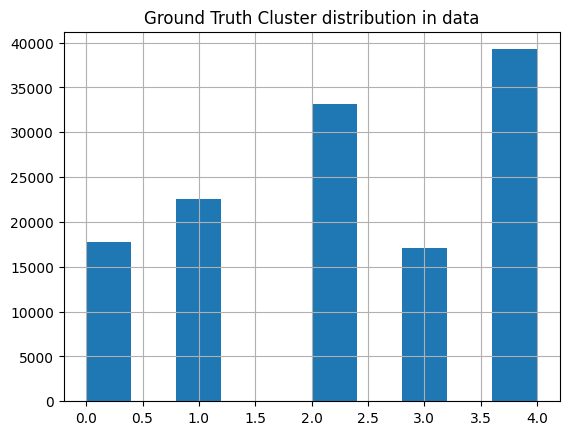

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

df['network'].hist()
plt.title("Ground Truth Cluster distribution in data")
plt.show()

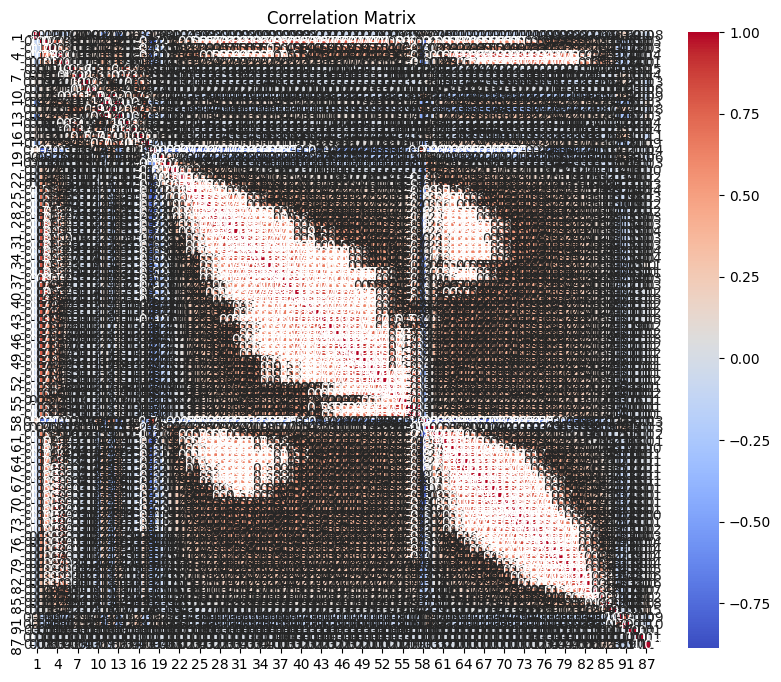

In [10]:
# Create correlation matrix between numerical features
correlation_matrix = df.drop('network', axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix')
plt.show()

In [11]:
# Find closely correlated features -
upper_triangle = np.triu(correlation_matrix, k=1)

# Find indices of correlations above the threshold
row_indices, col_indices = np.where(np.abs(upper_triangle) >= 0.95)

# Get the values and their corresponding row/column names
close_correlations = upper_triangle[row_indices, col_indices]
close_features = [(correlation_matrix.index[row], correlation_matrix.columns[col]) for row, col in zip(row_indices, col_indices)]
close_features

[(10, 12),
 (11, 13),
 (27, 28),
 (29, 30),
 (33, 34),
 (36, 37),
 (39, 40),
 (46, 47),
 (47, 48),
 (48, 49),
 (49, 50),
 (50, 51),
 (51, 52),
 (56, 57),
 (63, 64),
 (64, 65),
 (65, 66),
 (66, 67),
 (67, 68),
 (68, 69),
 (71, 72),
 (72, 73),
 (73, 74),
 (77, 78)]

Looking for features to drop to help reduce the impact of the curse of dimensionallty on the model calculations -

* the first two correlations (10 to 12 and 11 to 13) are correlation of similar features, mean and variance of Spectral Centroid and Spectral Roll off. We'll drop the spectral roll off features
* The remaning features with high correlation are the distribution features which are calculated from a changes in pixel intensity on a grid, thus the correlation of adjancent pixels makes sense in the context. We can a apply a sort of convolution similar to CNN and take the max value per observation of each group of highly correlated features (i.e. 71,72,73,74) as a new feature to replace all highly correlated features.

In [12]:
features_to_drop = [12, 13]
df.drop(features_to_drop, inplace=True, axis=1)

In [13]:
combined_corr_set = []
temp = close_features[2:][0]

for i in range(1, len(close_features[2:])):
    if temp[1] == close_features[2:][i][0]:
        temp = (temp[0], close_features[2:][i][1])
    else:
        combined_corr_set.append(temp)
        temp = close_features[2:][i]

combined_corr_set.append(temp)
combined_corr_set

[(27, 28),
 (29, 30),
 (33, 34),
 (36, 37),
 (39, 40),
 (46, 52),
 (56, 57),
 (63, 69),
 (71, 74),
 (77, 78)]

<Axes: ylabel='Density'>

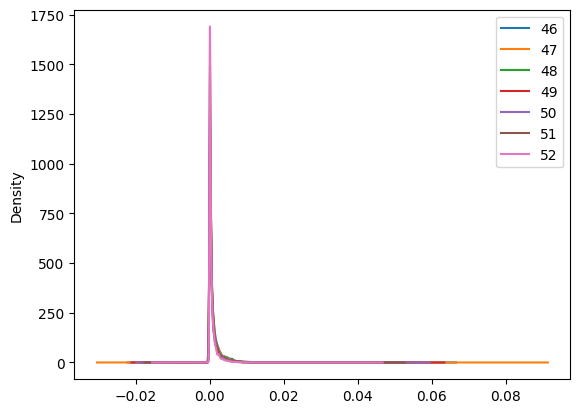

In [14]:
# Look at distribution ofa group of highly correlated features for example
df[list(range(46, 53))].plot(kind='kde')

In [15]:
for grp in combined_corr_set:
  df[grp] = df[list(range(grp[0], grp[1]+1))].max(axis=1)
  df.drop(list(range(grp[0], grp[1]+1)), axis=1, inplace=True)

In [16]:
df.head()

,1,2,3,4,5,6,7,8,9,10,...,"(27, 28)","(29, 30)","(33, 34)","(36, 37)","(39, 40)","(46, 52)","(56, 57)","(63, 69)","(71, 74)","(77, 78)"
0,71.0,1.701602,0.609488,6.247064,1.934570,0.014500,0.011053,0.101408,0.050983,3733.603760,...,0.003061,0.002654,0.001021,0.000398,0.000200,0.000003,0.000001,0.005780,0.000628,0.000586
1,56.0,7.061034,3.449135,24.636082,8.327330,0.012534,0.008328,0.183203,0.092624,3704.084473,...,0.023760,0.023345,0.016727,0.013140,0.011453,0.006164,0.001389,0.030610,0.012068,0.004854
2,25.0,2.232327,1.490304,15.819101,12.500734,0.008668,0.007681,0.078625,0.051767,3284.427246,...,0.009028,0.006694,0.003276,0.002522,0.001906,0.000630,0.000240,0.029688,0.006682,0.000084
3,52.0,1.141030,0.558418,6.686585,3.945288,0.006387,0.011432,0.048077,0.034091,3164.787109,...,0.004024,0.003044,0.002163,0.001423,0.000538,0.000185,0.000084,0.007969,0.003235,0.000025
4,90.0,2.810066,1.589357,18.414274,17.634733,0.013834,0.009399,0.117396,0.073247,3797.425049,...,0.009396,0.007688,0.008066,0.005981,0.003405,0.002632,0.000143,0.008301,0.031077,0.002006


In [17]:
# Fill in missing values -
# fill value will be the mean for the ground truth cluster
cluster_groupby = df.groupby('network')
columns_with_nan = df.columns[df.isna().any()].tolist()
df = df.fillna(cluster_groupby.transform('mean'))

In [18]:
# Verify no nulls left in the data
df.isna().any().any()

False

In [19]:
y = df['network']
df.drop('network', inplace=True, axis=1)

In [20]:
df_scaled = utils.standard_scaler(df)

the dataframe is of shape(129685, 67)
Number of numerical columns 67


In [21]:
num_of_clusters = y.unique()
len(num_of_clusters)

5

Another way to address the curse of dimensionality is reduce features using PCA

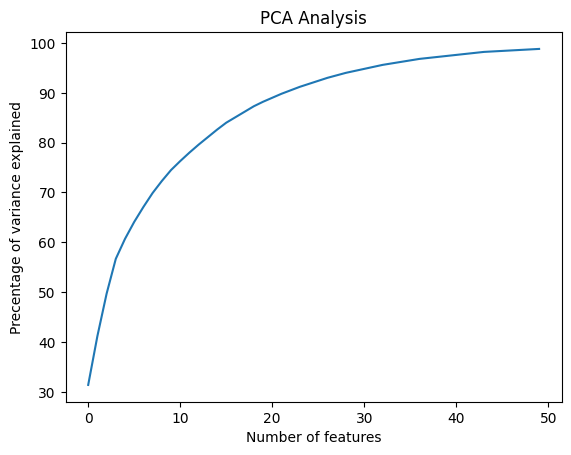

In [22]:
pca = PCA(n_components=50)
pca.fit(df_scaled)
variance = pca.explained_variance_ratio_
var = np.cumsum(np.round(variance, 3)*100)
plt.ylabel('Precentage of variance explained')
plt.xlabel('Number of features')
plt.title('PCA Analysis')
plt.plot(var)
plt.show()

In [23]:
# Choose n_componenets=10 which accounts for ~75% variance
pca = PCA(n_components=10)
df_pca = pd.DataFrame(pca.fit_transform(df_scaled))
df_pca.shape

(129685, 10)

Due to the excessive memory requirements of the agglomerativeClustering algorithm (O(n**2)) training the model on the complete dataset failed due to repeated MemoryErrors (the agglomerative algorithm alone took over 24GB of RAM. 

To solve this issue the algorithms will be trained on a subset (half) of the original data, stratified according to the network (cluster)

In [24]:
from sklearn.model_selection import train_test_split

df_pca_half1, _, y_half1, _ = train_test_split(df_pca, y, test_size=0.5, stratify=y, random_state=42)
df_pca_half1.shape

(64842, 10)

In [25]:
preprocessed_data = pd.concat([pd.DataFrame(df_pca_half1), y_half1], axis=1)
preprocessed_data.head()

,0,1,2,3,4,5,6,7,8,9,network
57816,8.620212,2.458109,1.684195,-0.010483,-0.709699,-1.990502,0.388885,-1.302690,0.229098,-1.812501,4.0
16599,-2.465351,-1.561633,0.525206,-4.507576,0.022591,-1.041731,-0.285979,1.403611,0.693295,-0.153607,2.0
30108,1.014658,-2.194711,-1.549494,-1.083186,0.302945,-1.483282,-0.699005,-3.146934,-3.144982,4.845402,2.0
1881,2.241728,-2.534416,-2.079271,-0.077166,-0.485060,-2.714056,0.386638,-1.539614,-2.128341,3.787433,2.0
44467,-5.013115,0.374866,0.737856,0.078695,0.589210,-0.748198,2.828716,-0.339099,-0.293099,2.772067,1.0


In [26]:
# Save the preprocessed data for submission
preprocessed_data.to_csv('Preprocessed data - TV News Channel Commercial Detection Dataset', index=False, header=False)

# 3: Methods Selecting the optimal number of clusters


Working on KMeans


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [1:21:57<00:00, 61.47s/it]


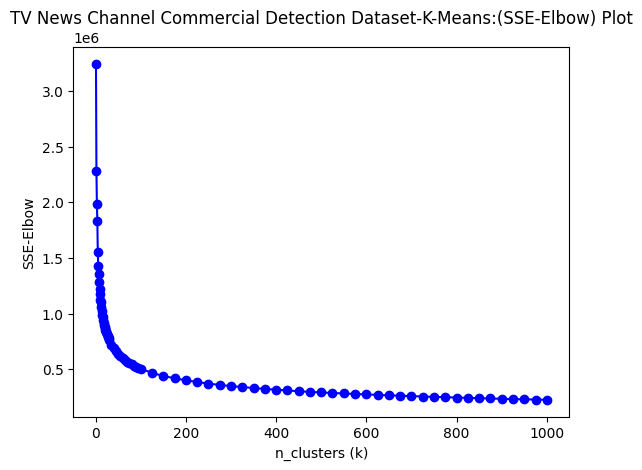

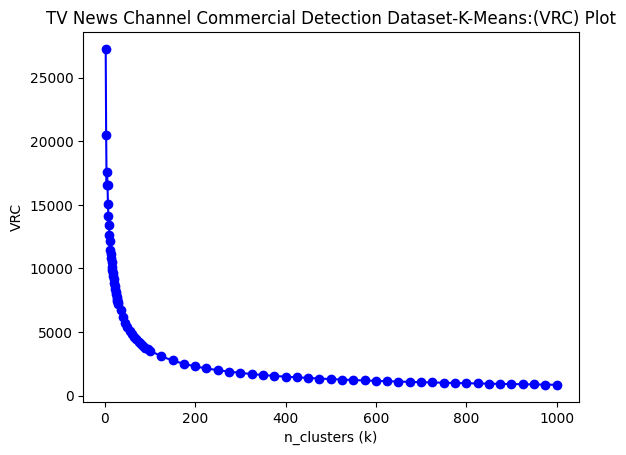

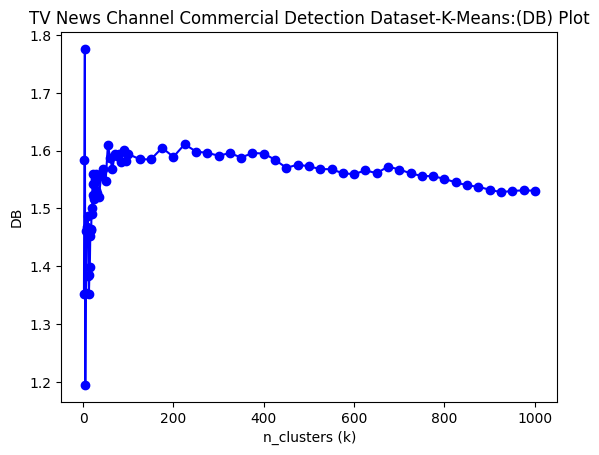

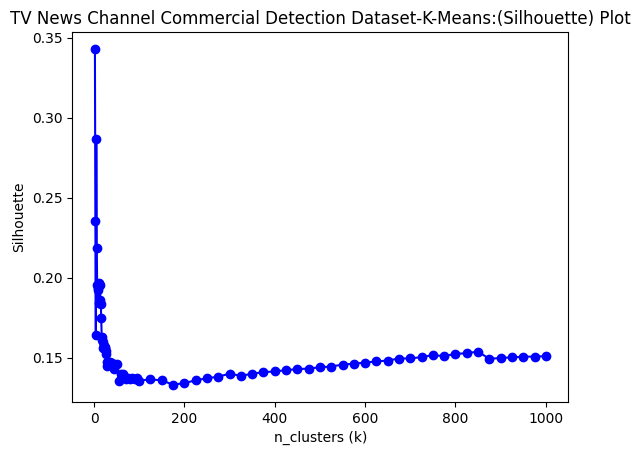

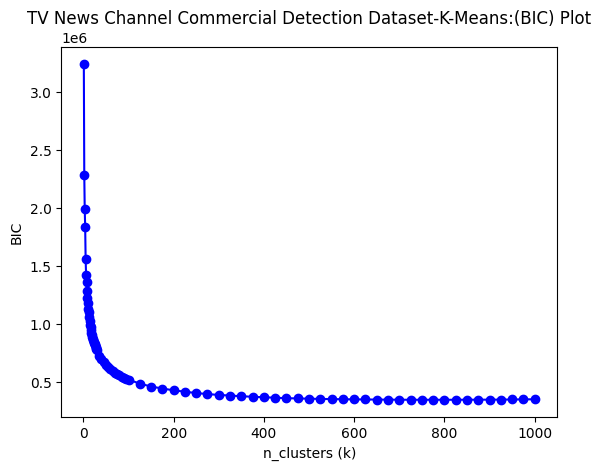

Working on DBSCAN


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [23:17<00:00, 69.86s/it]


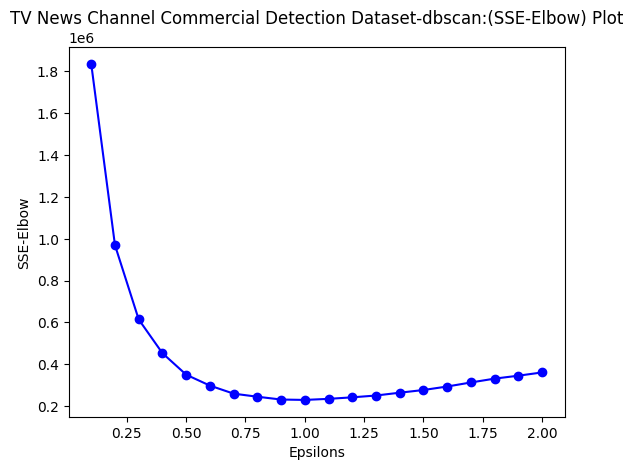

Working on OPTICS


  0%|                                                                                                                                                                                                              | 0/20 [00:00<?, ?it/s]C:\Users\Or\PycharmProjects\MachineLearning_Ass4\venv\lib\site-packages\sklearn\cluster\_optics.py:932: RuntimeWarning:

divide by zero encountered in divide

C:\Users\Or\PycharmProjects\MachineLearning_Ass4\venv\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning:

invalid value encountered in matmul

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [2:31:22<00:00, 454.10s/it]


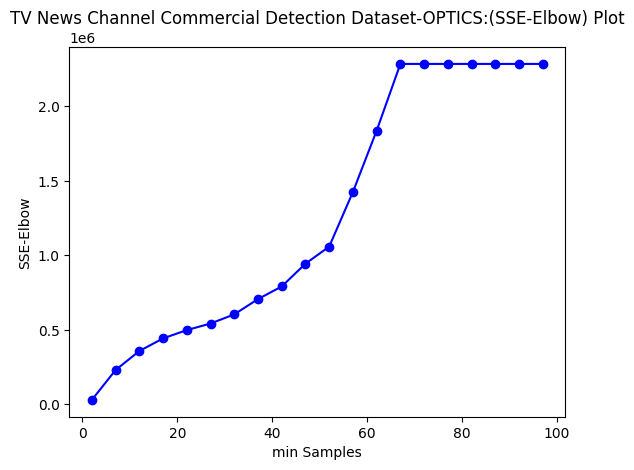

Working on AgglomerativeClustering


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [1:46:17<00:00, 318.86s/it]


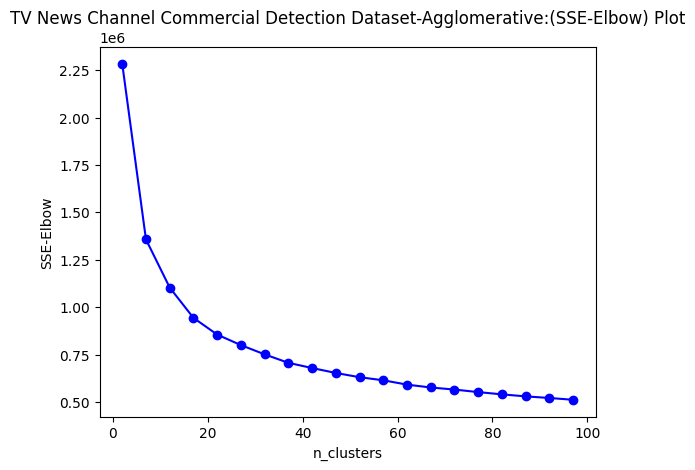

C:\Users\Or\PycharmProjects\MachineLearning_Ass4\venv\lib\site-packages\plotly\matplotlylib\renderer.py:647: UserWarning:

Looks like the annotation(s) you are trying 
to draw lies/lay outside the given figure size.

Therefore, the resulting Plotly figure may not be 
large enough to view the full text. To adjust 
the size of the figure, use the 'width' and 
'height' keys in the Layout object. Alternatively,
use the Margin object to adjust the figure's margins.



In [27]:
utils.calc_scores_for_all(df_pca_half1, dataset='TV News Channel Commercial Detection Dataset')